## Introduction

[PRAMS](https://www.cdc.gov/prams/index.htm), the Pregnancy Risk Assessment Monitoring System is a surveillance project managed by the Centers for Disease Control and Prevention. With support from state organizations, PRAMS is able to capture data from around 81% of all births that occur in the United States. This information allows them to monitor health trends affecting mothers and newborn infants and make policy recommendations to improve their health outcomes.

**Project Understanding:** APGAR Score is a metric doctors use to measure the overall health of a newborn infant, and is a key indicator of health outcomes collected by the PRAMS organization. PRAMS has tasked me with creating a predictive machine learning model that can alert health professionals of potential newborn health emergencies while the mother is still pregnant. Additionally, they are interested in which factors are the most important predictors of newborn health so that they may effectively direct the organization's resources toward saving lives.

**Data Source:** The data for this project was obtained from the [Vital Statistics Natality Birth Data](https://www.nber.org/research/data/vital-statistics-natality-birth-data) produced by the [National Center for Health Statistics](https://www.cdc.gov/nchs/).

Note: This project is performed for academic purposes only. I am not affiliated with any of the listed organizations.

In [1]:
# Import resources
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import gc
import warnings
import seaborn as sns
import xgboost
from pathlib import Path  
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,\
ExtraTreesClassifier, VotingClassifier, StackingRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,\
confusion_matrix, plot_roc_curve, plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

## Import and Clean Data

The function below runs a python file stored in this repository. For full information and list of columns, see functions.py. Additionally, a dataset overview can be found in the [Vital Statistics Natality Birth Data readme](https://www.nber.org/research/data/vital-statistics-natality-birth-data), a copy of which can be found in this directory.

import_and_clean_data() performs the following:
- Reads csv file into dataframe
- Removes unneeded columns from the dataset
- Renames columns with more interpretable labels
- Bins unwieldy variables

Columns were removed from the analysis for several reasons:
- They are storing metadata about the collection of the dataset
- They were pre-processed for a specific purpose outside the scope of this analysis
- They are slight variations of existing columns which are more applicable to this project
- They represent events that happen after birth has already occurred

In [2]:
# Suppress an unneeded warning
warnings.filterwarnings('ignore')

# Import stored data cleaning function
import functions as fn

df = fn.import_and_clean_data('data/nat2019us.csv')

In [3]:
# Confirm dataset was loaded correctly
df.head()

,birth_place,mother_age,mother_native,mother_race,mother_hispanic,marital_status,mother_education,father_age,living_children,deceased_children,...,hepatitis_b,hepatitis_c,steroids,antibiotics,chorioamnionitis,apgar_score,plural_pregnancy,infant_sex,weeks_gestation,down_syndrome
0,hospital,29,Y,native_american,N,married,hs_or_lower,31.0,1.0,0.0,...,N,N,N,N,N,8,1,F,40.0,N
1,hospital,40,N,asian/pi,N,married,college_or_higher,39.0,2.0,0.0,...,N,N,N,N,N,9,1,F,39.0,N
2,hospital,30,Y,native_american,N,married,hs_or_lower,36.0,7.0,0.0,...,N,N,N,Y,N,8,1,M,38.0,N
3,hospital,25,Y,white,N,married,college_or_higher,26.0,1.0,0.0,...,N,N,N,N,N,9,1,M,38.0,N
4,hospital,38,Y,white,N,unmarried,college_or_higher,31.0,1.0,0.0,...,N,N,Y,N,N,9,1,F,37.0,N


In [4]:
# Overview of chosen features
df.columns

Index(['birth_place', 'mother_age', 'mother_native', 'mother_race',
       'mother_hispanic', 'marital_status', 'mother_education', 'father_age',
       'living_children', 'deceased_children', 'terminations',
       'months_prenatal_care', 'prenatal_visits', 'food_assistance',
       'prepregnancy_daily_cig', 'first_tri_daily_cig', 'second_tri_daily_cig',
       'third_tri_daily_cig', 'height', 'bmi', 'delivery_weight',
       'weight_gain', 'diabetes', 'gestational_diabetes', 'hypertension',
       'gestational_hypertension', 'eclampsia', 'previous_premature_birth',
       'infertility_treatment', 'fertility_drugs', 'assisted_reproduction',
       'previous_cesareans', 'gonorrhea', 'syphilis', 'chlamydia',
       'hepatitis_b', 'hepatitis_c', 'steroids', 'antibiotics',
       'chorioamnionitis', 'apgar_score', 'plural_pregnancy', 'infant_sex',
       'weeks_gestation', 'down_syndrome'],
      dtype='object')

In [5]:
# Dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3757582 entries, 0 to 3757581
Data columns (total 45 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   birth_place               object 
 1   mother_age                int64  
 2   mother_native             object 
 3   mother_race               object 
 4   mother_hispanic           object 
 5   marital_status            object 
 6   mother_education          object 
 7   father_age                float64
 8   living_children           float64
 9   deceased_children         float64
 10  terminations              float64
 11  months_prenatal_care      float64
 12  prenatal_visits           float64
 13  food_assistance           object 
 14  prepregnancy_daily_cig    float64
 15  first_tri_daily_cig       float64
 16  second_tri_daily_cig      float64
 17  third_tri_daily_cig       float64
 18  height                    float64
 19  bmi                       float64
 20  delivery_weight         

## Missing Values

I have chosen to keep as many entries as possible with missing information with the intent of later imputation. In my initial exploratory data analysis I found that entries with missing values tended to be associated with higher rates of unhealthy newborns, which suggests that these entries may have important information for the model to capture. 

In [6]:
# Confirm missing values were marked as NaN for future imputation
df.isna().sum()

birth_place                    138
mother_age                       0
mother_native                 7947
mother_race                      0
mother_hispanic              36110
marital_status              447653
mother_education             54506
father_age                  433033
living_children               6076
deceased_children             8540
terminations                  9561
months_prenatal_care         85189
prenatal_visits              92951
food_assistance              43591
prepregnancy_daily_cig       19477
first_tri_daily_cig          19400
second_tri_daily_cig         19331
third_tri_daily_cig          38566
height                       20400
bmi                              0
delivery_weight              51603
weight_gain                 112083
diabetes                      3450
gestational_diabetes          3450
hypertension                  3450
gestational_hypertension      3450
eclampsia                     3450
previous_premature_birth      3450
infertility_treatmen

## Target Engineering

The Target of the model will be the [5-minute APGAR score](https://www.ncbi.nlm.nih.gov/books/NBK470569/) of the newborn infant, which lies on a scale between 0 and 10. A score between 7 and 10 typically means that the health outlook of the infant is positive, whereas a score between 0 and 6 means the infant will likely require medical intervention. For the purposes of this analysis, I will be filtering the data into these two categories and dropping the small portion of entries with missing APGAR score values.

In [7]:
df['apgar_score'].value_counts()

9     3094327
8      417480
7       77895
10      75873
6       30450
5       16107
99      14673
4        9028
1        7415
3        6507
2        5781
0        2046
Name: apgar_score, dtype: int64

In [8]:
# Bin APGAR score into binary target
df['apgar_score'].replace(to_replace=list(range(0, 7)), value=1, inplace=True)
df['apgar_score'].replace(to_replace=list(range(7, 11)), value=0, inplace=True)

# Drop rows with missing APGAR score
df.drop(df.loc[df['apgar_score']==99].index, inplace=True)

In [9]:
df['apgar_score'].value_counts(normalize=True)

0    0.979339
1    0.020661
Name: apgar_score, dtype: float64

After engineering the target variable, approximately 2% of the newborns in the dataset had a low APGAR score. This is a relatively rare event compared to a high APGAR score, so resampling may be needed to offset this class imbalance.

## Feature Overview

Iteratively plot distributions of the features to gain a better understanding of the dataset.

In [10]:
# Define numerical and categorical features
df_cat = df.select_dtypes(include=['object'])
df_num = df.select_dtypes(include=['int64', 'float64'])

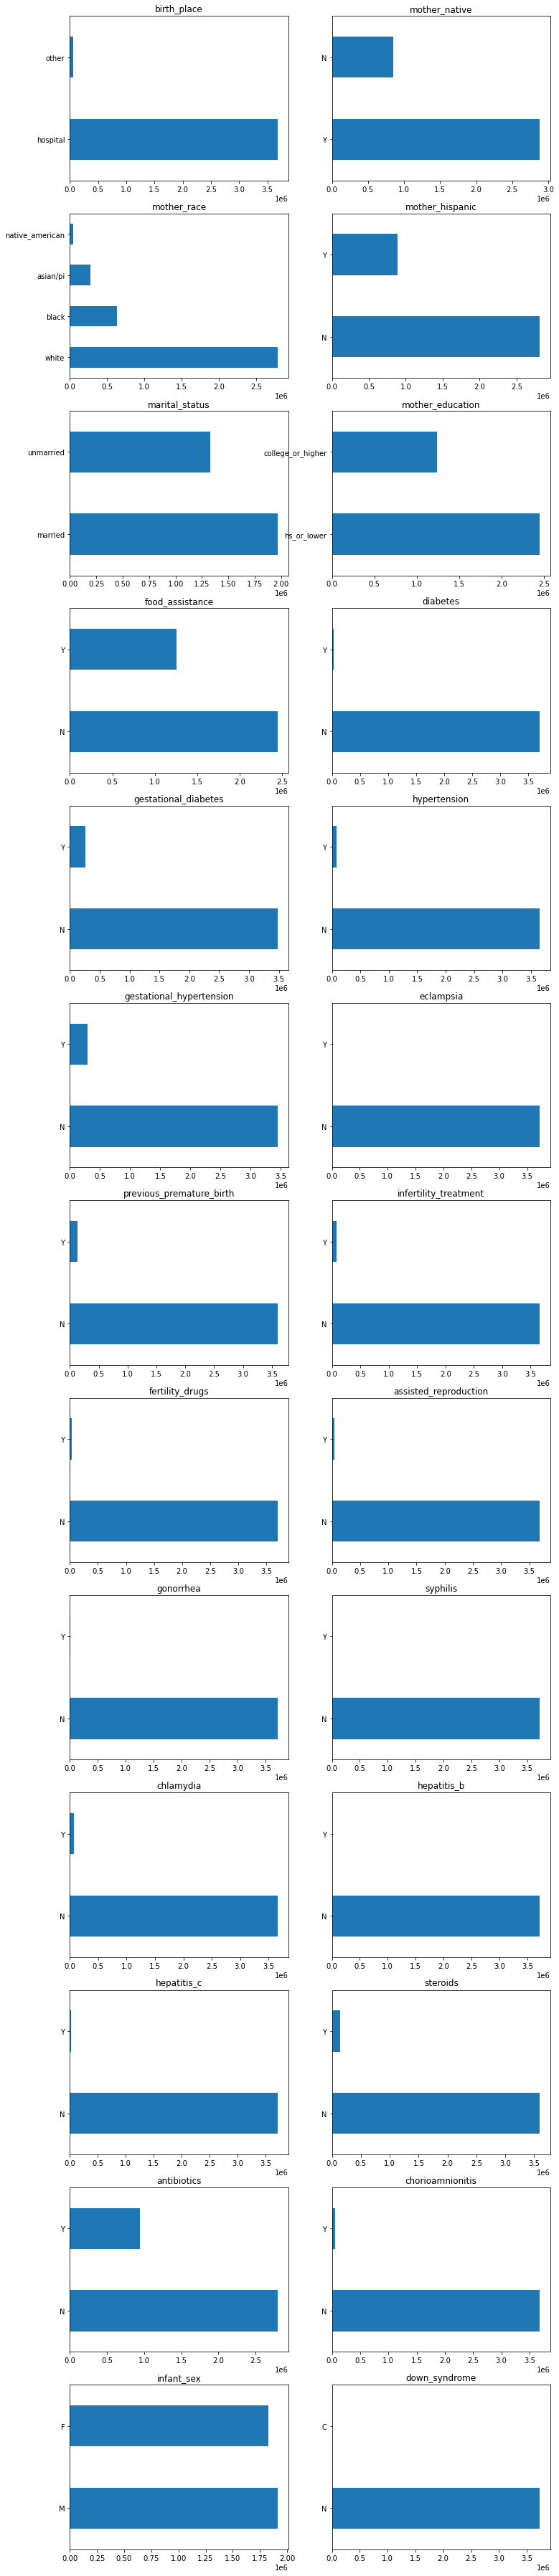

In [11]:
# Distribution of categorical features
fig, axis = plt.subplots(nrows = int((len(df_cat.columns)/2)), ncols = 2, figsize=(12,len(df_cat.columns)*2.5))

for i, subplot in zip(df_cat.columns, axis.ravel()):
    df_cat[i].value_counts().plot(kind='barh', ax=subplot, title = i)

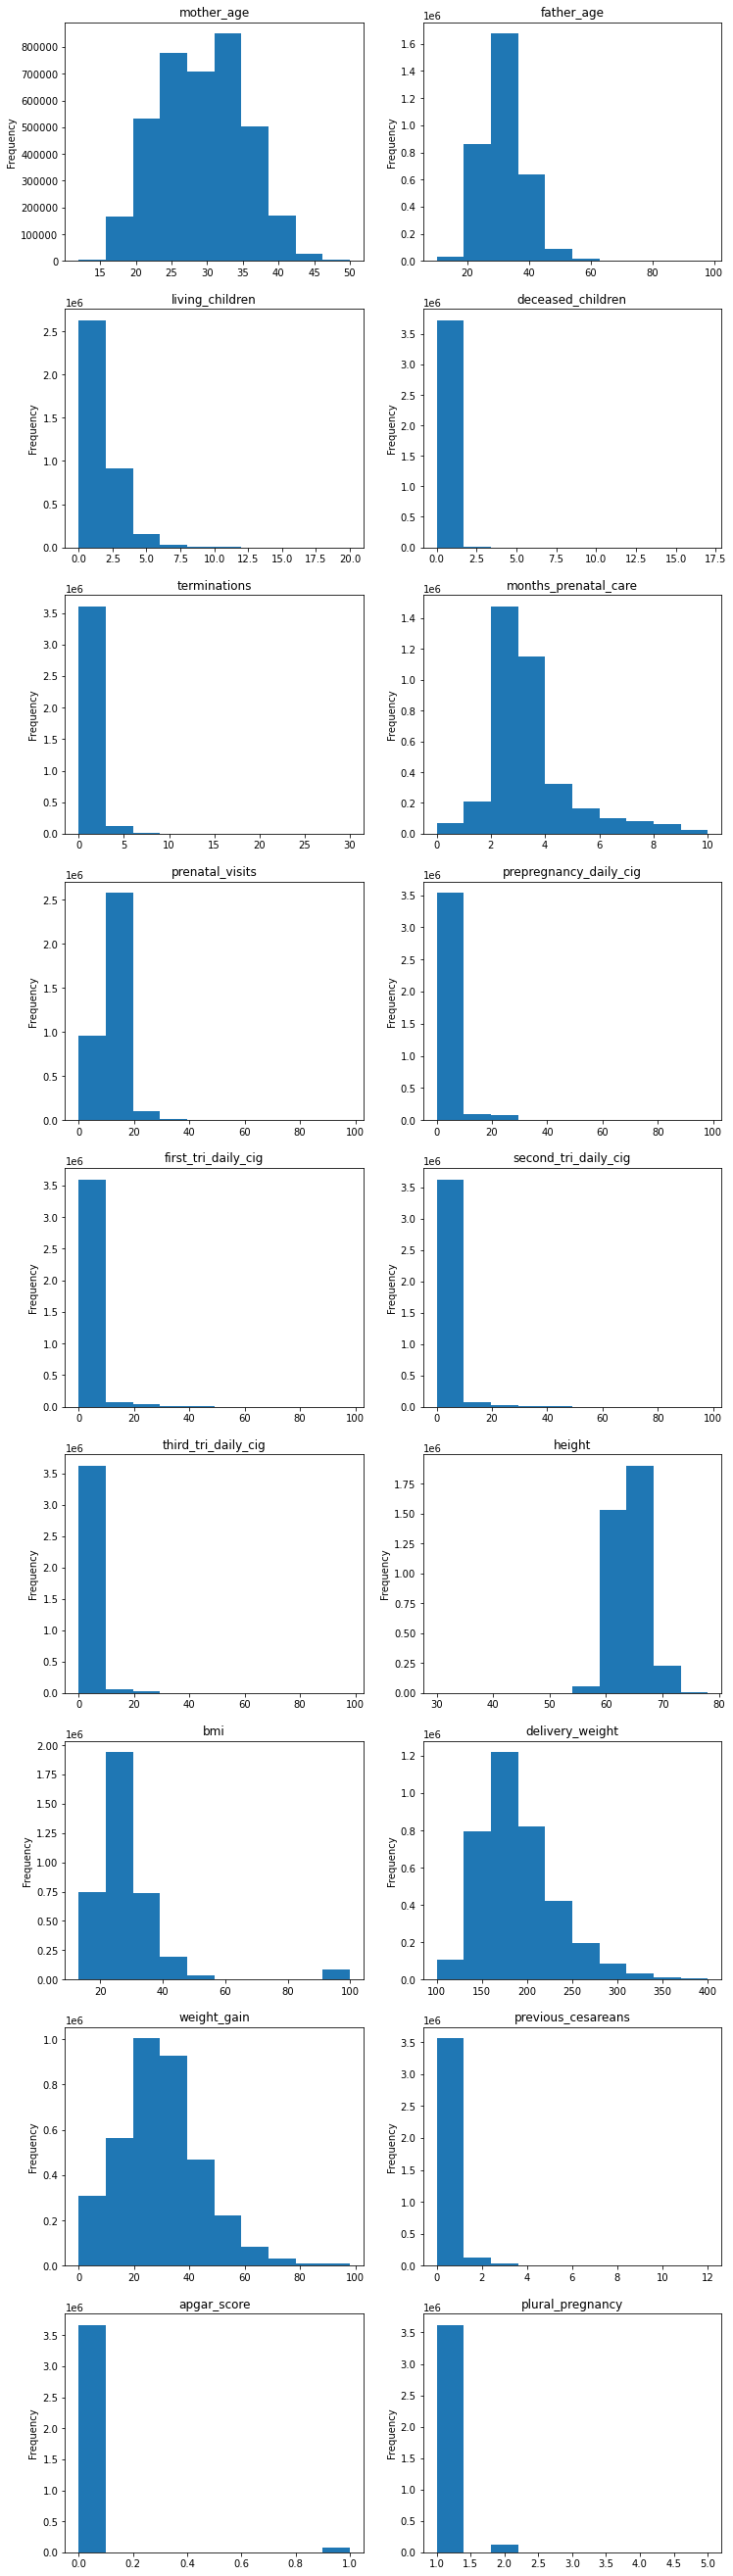

In [12]:
# Distribution of numerical features
fig, axis = plt.subplots(nrows = int((len(df_num.columns)/2)), ncols = 2, figsize=(12,len(df_num.columns)*2.5))

for i, subplot in zip(df_num.columns, axis.ravel()):
    df_num[i].plot(kind='hist', ax=subplot, title = i)

Additionally, I will plot each feature against the percentage of low apgar score newborns to gain an rough picture of how the features interact with the target.

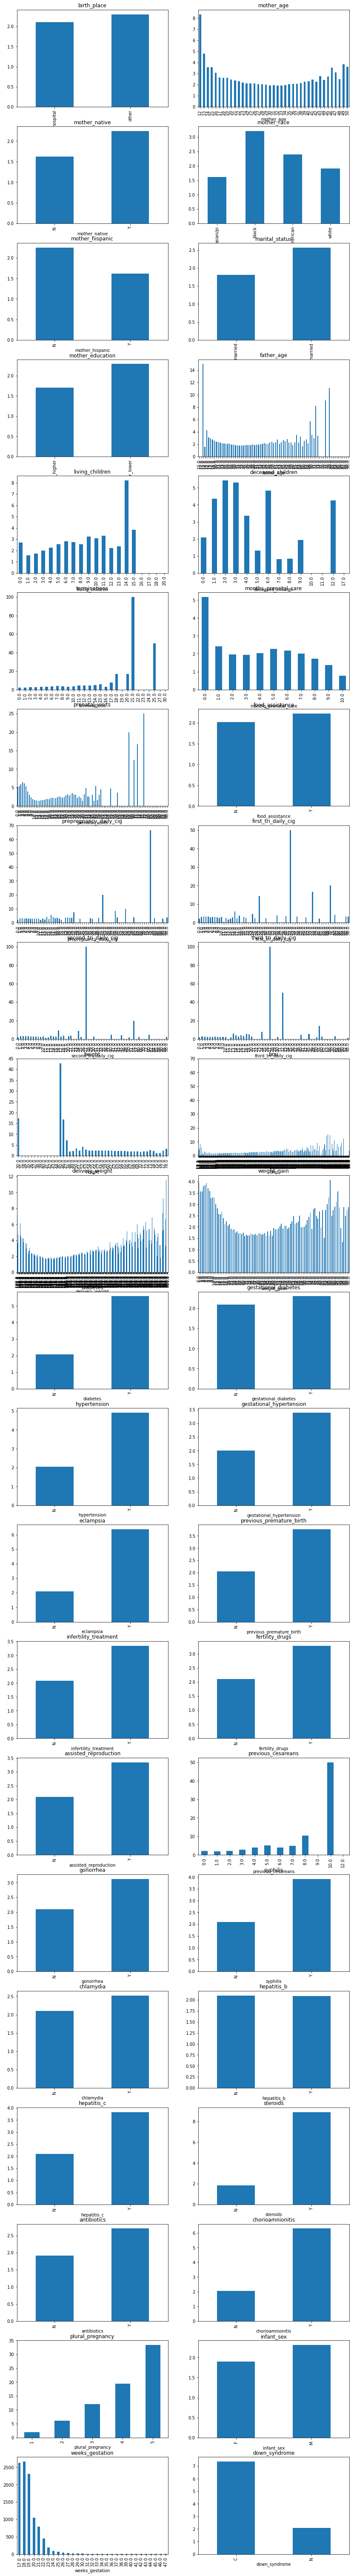

In [13]:
# Plot proportion of each feature to APGAR score
dfx = df.drop('apgar_score', axis=1)

fig, axis = plt.subplots(nrows = int((len(dfx.columns)/2)), ncols = 2, figsize=(14,len(dfx.columns)*2.5))

for i, subplot in zip(dfx.columns, axis.ravel()):
    
    counts = (df[[i, 'apgar_score']]
              .groupby([i, 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

    counts['percent_low_apgar'] = (counts[1]/counts[0])*100
    
    counts['percent_low_apgar'].plot(kind='bar', ax=subplot, title = i)


## Featured Visualizations

Below are several chosen plots that will be used for explanatory purposes in the presentation.

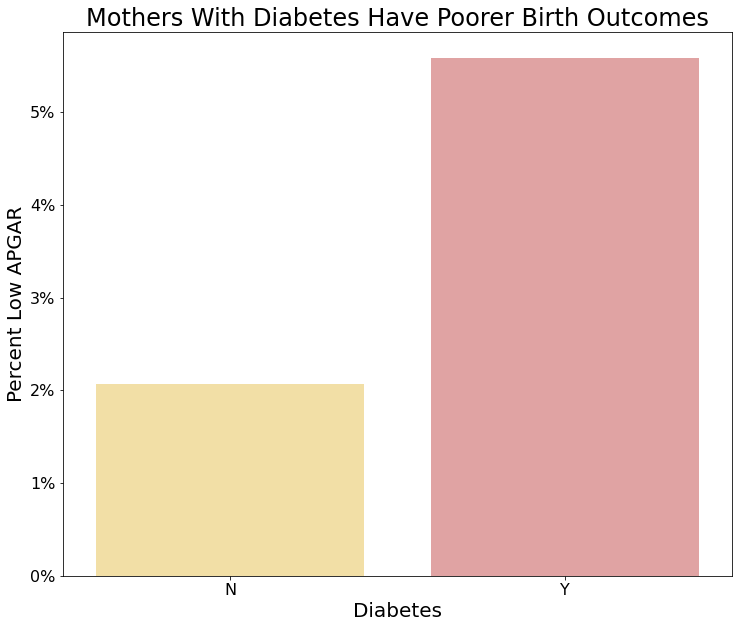

In [14]:
# Generate dataframe containing proportion of feature with low APGAR score
counts = (df[['diabetes', 'apgar_score']]
              .groupby(['diabetes', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[1]/counts[0])*100

# PLot diabetes graph
fig, ax = plt.subplots( figsize=(12,10))
sns.barplot(ax=ax, x=counts.index, y=counts['percent_low_apgar'], palette=['#ffe599', '#ea9999'])

plt.title("Mothers With Diabetes Have Poorer Birth Outcomes", fontsize = 24)
ax.set_ylabel("Percent Low APGAR", fontsize = 20)
ax.set_xlabel("Diabetes", fontsize = 20)
ax.yaxis.set_major_formatter(tick.PercentFormatter(decimals=0))
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

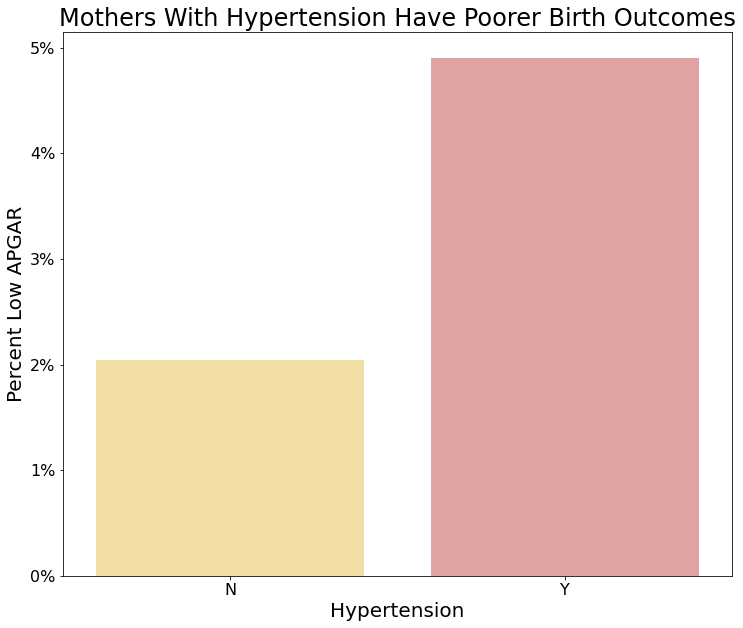

In [15]:
# Generate dataframe containing proportion of feature with low APGAR score
counts = (df[['hypertension', 'apgar_score']]
              .groupby(['hypertension', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[1]/counts[0])*100

#Plot Hypertension graph
fig, ax = plt.subplots( figsize=(12,10))
sns.barplot(ax=ax, x=counts.index, y=counts['percent_low_apgar'], palette=['#ffe599', '#ea9999'])

plt.title("Mothers With Hypertension Have Poorer Birth Outcomes", fontsize = 24)
ax.set_ylabel("Percent Low APGAR", fontsize = 20)
ax.set_xlabel("Hypertension", fontsize = 20)
ax.yaxis.set_major_formatter(tick.PercentFormatter(decimals=0))
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

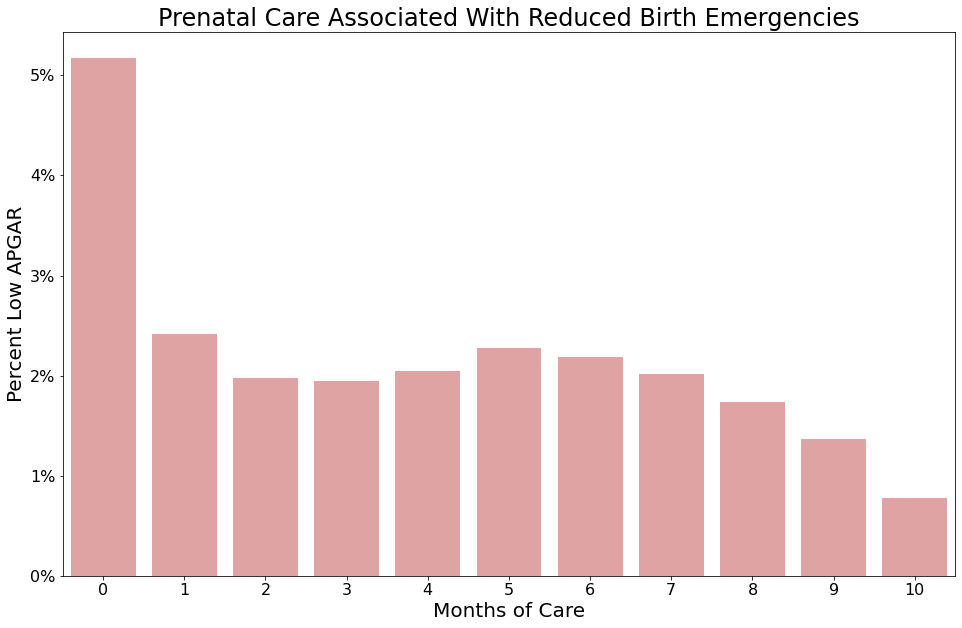

In [16]:
# Generate dataframe containing proportion of feature with low APGAR score
counts = (df[['months_prenatal_care', 'apgar_score']]
              .groupby(['months_prenatal_care', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[1]/counts[0])*100


fig, ax = plt.subplots( figsize=(16,10))
sns.barplot(ax=ax, x=counts.index, y=counts['percent_low_apgar'], palette=['#ea9999'])

#Plot prenetal care graph
plt.title("Prenatal Care Associated With Reduced Birth Emergencies", fontsize = 24)
ax.set_ylabel("Percent Low APGAR", fontsize = 20)
ax.set_xlabel("Months of Care", fontsize = 20)
ax.yaxis.set_major_formatter(tick.PercentFormatter(decimals=0))
ax.set_xticklabels(counts.index.astype(int))
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

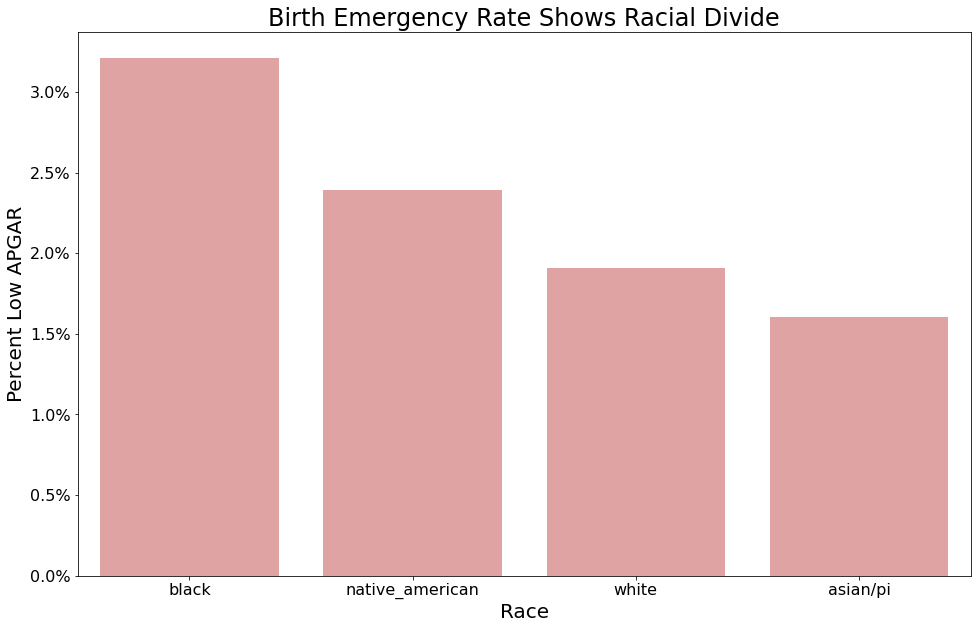

In [17]:
# Generate dataframe containing proportion of feature with low APGAR score
counts = (df[['mother_race', 'apgar_score']]
              .groupby(['mother_race', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[1]/counts[0])*100
counts.sort_values(by='percent_low_apgar', ascending=False, inplace=True)

#Plot race graph
fig, ax = plt.subplots( figsize=(16,10))
sns.barplot(ax=ax, x=counts.index, y=counts['percent_low_apgar'], palette=['#ea9999'])

plt.title("Birth Emergency Rate Shows Racial Divide", fontsize = 24)
ax.set_ylabel("Percent Low APGAR", fontsize = 20)
ax.set_xlabel("Race", fontsize = 20)
ax.yaxis.set_major_formatter(tick.PercentFormatter(decimals=1))
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

## Oversampling

Because the dataset is so massive, it must be sampled into a smaller size due to hardware constraints. This could be rectified in future analysis with cloud computing. However, the dataset's size provides an opportunity to generate a model training dataset without the class imbalance found in the full version. This may reduce performance of the model by causing it to overpredict the minority class in testing, but I believe giving the model more low-APGAR score entries to train on will be worthwhile when misidentifying an emergency case is so costly.

In [18]:
# Create testing set with original target distribution
df_test = df.sample(n=20000, random_state=27, axis=0)
df_test['apgar_score'].value_counts(normalize=True)

0    0.979
1    0.021
Name: apgar_score, dtype: float64

In [19]:
# Remove the rows sampled for the test set so they do not appear in the training set
df_drop = df.drop(df_test.index, axis=0)
df_drop.shape

(3722909, 45)

In [20]:
# Filter dropped dataset by target
df_target1 = df_drop[df_drop['apgar_score'] == 1]
df_target0 = df_drop[df_drop['apgar_score'] == 0]

# Sample an equal number from each target dataframe
df_target1_join = df_target1.sample(n=10000, random_state=27, axis=0)
df_target0_join = df_target0.sample(n=10000, random_state=27, axis=0)

# Merge the two subsampled datasets into training set
df_train = pd.concat([df_target1_join, df_target0_join])
df_train['apgar_score'].value_counts(normalize=True)

1    0.5
0    0.5
Name: apgar_score, dtype: float64

## Train Test Variables

Separate training and testing datasets by feature and target.

In [21]:
X_train = df_train.drop('apgar_score', axis=1)
y_train = df_train['apgar_score']

X_test = df_test.drop('apgar_score', axis=1)
y_test = df_test['apgar_score']

## Free Memory

Because the dataframes are so large, clearing unused variables is necessary to stabilize notebook performance.

In [22]:
del df, df_target1, df_target0, df_target1_join, df_target0_join, df_test, df_drop
gc.collect()

9426

## Process Data for Pre-Modeling Exploration

In [23]:
# Copy dataframes
X_train2 = X_train.copy()
X_test2 = X_test.copy()

# Select columns by data type
numeric_features = X_train2.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train2.select_dtypes(include=['object']).columns

# Instantiate processors 
num_impute = SimpleImputer(strategy="median")
cat_impute = SimpleImputer(strategy="most_frequent")
scaler = MinMaxScaler()
ohe = OneHotEncoder(drop='first', handle_unknown = 'error', sparse=False)

# Separate by data type
X_train2_obj = X_train2[categorical_features]
X_test2_obj = X_test2[categorical_features]


In [24]:
# Transform categorical data
cat_impute.fit(X_train2_obj)
X_train2_imp = cat_impute.transform(X_train2_obj)
X_test2_imp = cat_impute.transform(X_test2_obj)

ohe.fit(X_train2_imp)
X_train_ohe = ohe.transform(X_train2_imp)
X_test_ohe = ohe.transform(X_test2_imp)

In [25]:
# Transform numerical data
X_train2_num = X_train2[numeric_features]
X_test2_num = X_test2[numeric_features]

num_impute.fit(X_train2_num)
X_train2_impnum = num_impute.transform(X_train2_num)
X_test2_impnum = num_impute.transform(X_test2_num)

scaler.fit(X_train2_impnum)
X_train_scaled = scaler.transform(X_train2_impnum)
X_test_scaled = scaler.transform(X_test2_impnum)

In [26]:
# Convert processed data into dataframes for ease of interpetability 
X_train_scaled = pd.DataFrame(X_train_scaled, 
                              columns = numeric_features,
                              index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, 
                             columns = numeric_features,
                             index=X_test.index)

X_train_ohe = pd.DataFrame(X_train_ohe, 
                           columns = ohe.get_feature_names(input_features = categorical_features),
                           index=X_train.index)
X_test_ohe = pd.DataFrame(X_test_ohe, 
                          columns = ohe.get_feature_names(input_features = categorical_features),
                          index=X_test.index)

X_train_processed = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test_processed = pd.concat([X_test_ohe, X_test_scaled], axis=1)

## Multicolinearity Check

In [27]:
# Generate correlation matrix
corr_matrix = X_train_processed.corr().abs()
corr_matrix

,birth_place_other,mother_native_Y,mother_race_black,mother_race_native_american,mother_race_white,mother_hispanic_Y,marital_status_unmarried,mother_education_hs_or_lower,food_assistance_Y,diabetes_Y,...,first_tri_daily_cig,second_tri_daily_cig,third_tri_daily_cig,height,bmi,delivery_weight,weight_gain,previous_cesareans,plural_pregnancy,weeks_gestation
birth_place_other,1.000000,0.033294,0.039623,0.000606,0.042514,0.037176,0.059159,0.029841,0.071747,0.014355,...,0.011100,0.008334,0.011648,0.029855,0.013176,0.038240,0.010515,0.037131,0.027828,0.056283
mother_native_Y,0.033294,1.000000,0.045968,0.033479,0.135303,0.329609,0.122328,0.012977,0.050368,0.009660,...,0.095766,0.089524,0.082933,0.159610,0.035676,0.183044,0.081041,0.031467,0.019564,0.014613
mother_race_black,0.039623,0.045968,1.000000,0.056068,0.818539,0.193146,0.312562,0.164326,0.172581,0.018472,...,0.038390,0.033678,0.032430,0.028599,0.096965,0.078091,0.062447,0.044808,0.041501,0.168054
mother_race_native_american,0.000606,0.033479,0.056068,1.000000,0.170588,0.015498,0.052610,0.042418,0.042053,0.024830,...,0.009919,0.012850,0.027315,0.002310,0.009637,0.015496,0.008592,0.025003,0.008750,0.002030
mother_race_white,0.042514,0.135303,0.818539,0.170588,1.000000,0.234009,0.221602,0.089464,0.123634,0.021696,...,0.057654,0.050923,0.045549,0.038588,0.060061,0.005957,0.072150,0.041758,0.027405,0.137785
mother_hispanic_Y,0.037176,0.329609,0.193146,0.015498,0.234009,1.000000,0.007826,0.169034,0.166915,0.001437,...,0.086039,0.082639,0.075615,0.220768,0.011513,0.069518,0.066140,0.027458,0.014371,0.000522
marital_status_unmarried,0.059159,0.122328,0.312562,0.052610,0.221602,0.007826,1.000000,0.363963,0.305445,0.000804,...,0.136072,0.122813,0.115610,0.054812,0.059797,0.030799,0.005954,0.009580,0.003727,0.096563
mother_education_hs_or_lower,0.029841,0.012977,0.164326,0.042418,0.089464,0.169034,0.363963,1.000000,0.366515,0.036101,...,0.123345,0.113252,0.103764,0.142444,0.090334,0.052999,0.068395,0.054099,0.017294,0.091213
food_assistance_Y,0.071747,0.050368,0.172581,0.042053,0.123634,0.166915,0.305445,0.366515,1.000000,0.042018,...,0.094917,0.083694,0.077804,0.098839,0.042201,0.059382,0.027142,0.039775,0.006607,0.008033
diabetes_Y,0.014355,0.009660,0.018472,0.024830,0.021696,0.001437,0.000804,0.036101,0.042018,1.000000,...,0.001755,0.001214,0.002239,0.001824,0.052760,0.094355,0.012109,0.042134,0.009545,0.035814


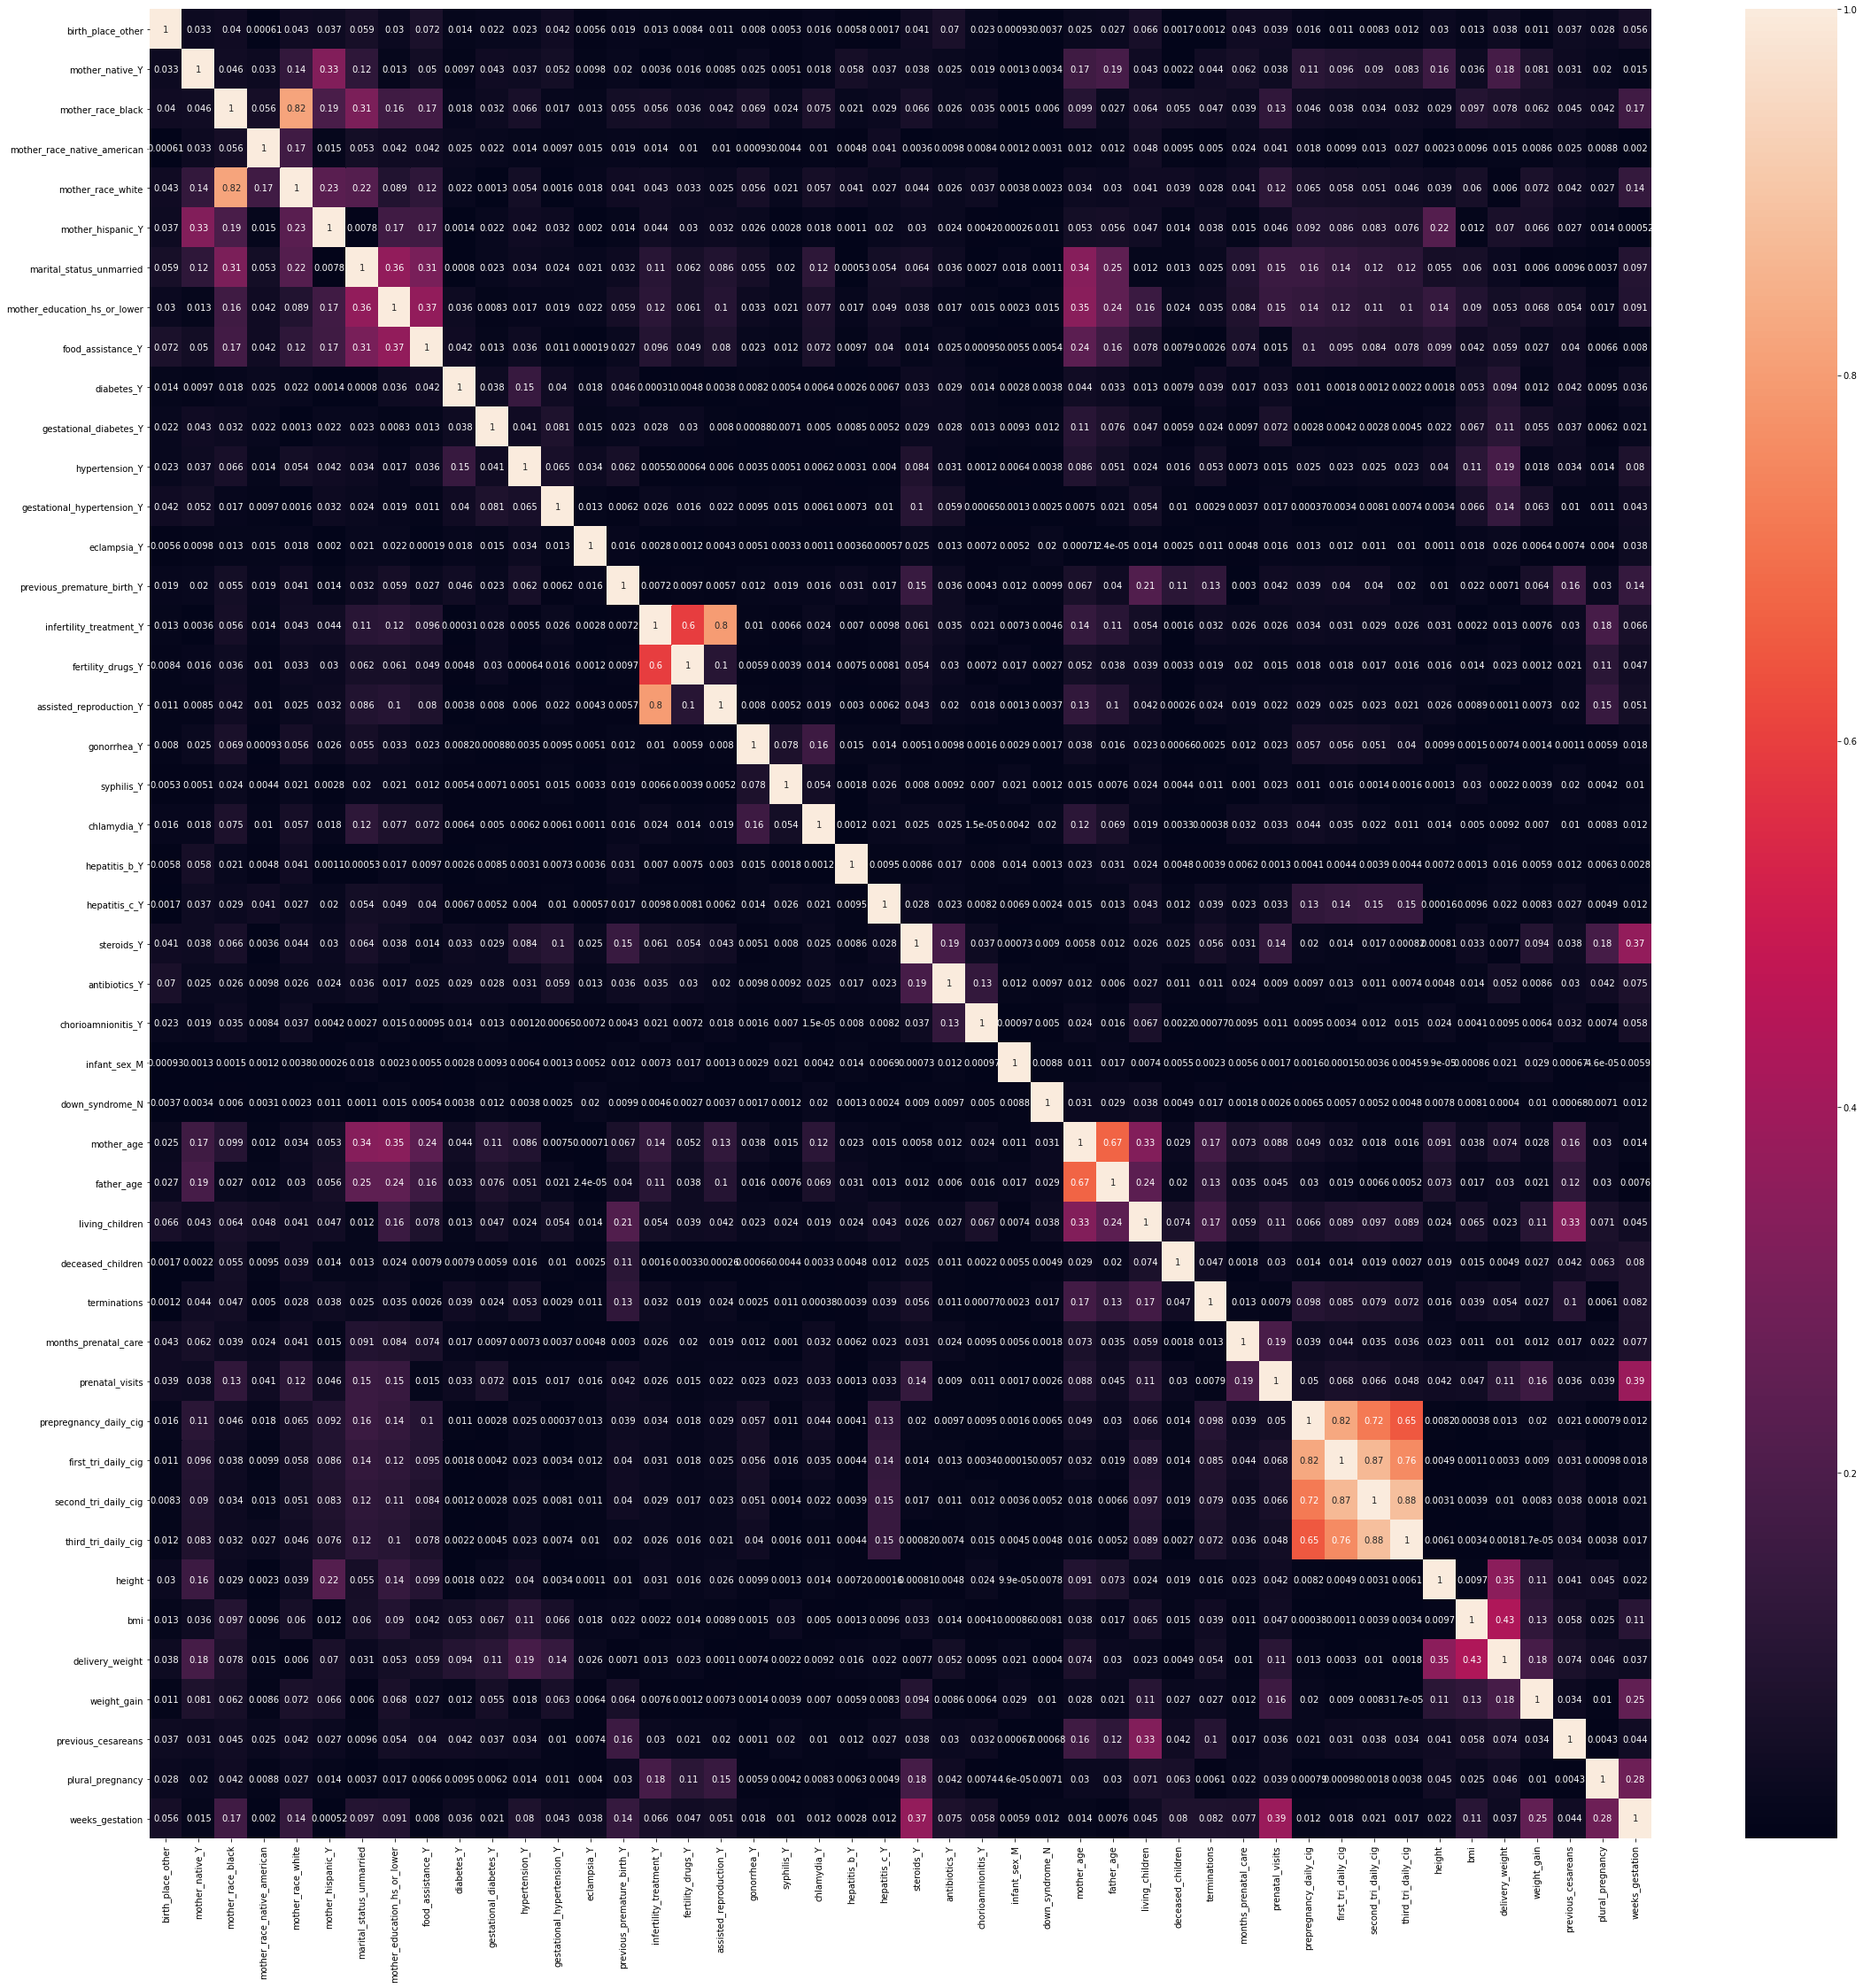

In [28]:
# Generate heatmap of correlation matrix
plt.figure(figsize=(38,38))
sns.heatmap(corr_matrix, annot=True)
plt.show()

Using a traditional value for high multicolinearity of 0.7 or greater, the heatmap shows several potentially problematic features. Race multicolinearity is expected after one-hot encoding the data to numeric values, and that information is important to preserve for demographic analysis. However, there is a strong correlation between mothers taking infertility drugs and going through assisted reproduction. The less descriptive column of these two should be dropped. Smoking cigarettes at one point of pregnancy is similarly correlated with smoking during other points of pregnancy, and these features could easily be binned or dropped.

## Feature Importance Using Extra Trees Classifier

Feature importance is important for interpreting the results of the model into actionable recommendations. Additionally, it may serve as a metric by which to decide which columns are worth keeping in the model in future analysis.

In [29]:
# Building the model
extra_tree_forest = ExtraTreesClassifier(n_estimators = 100,
                                        criterion ='entropy', max_depth=3, random_state=27)
  
# Training the model
extra_tree_forest.fit(X_train_processed, y_train.values.ravel())
  
# Computing the importance of each feature
feature_importance = extra_tree_forest.feature_importances_
  
# Normalizing the individual importances
feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        extra_tree_forest.estimators_],
                                        axis = 0)

In [30]:
ext = pd.DataFrame(list(feature_importance_normalized), index=list(X_train_processed.columns))
ext_sorted = ext.sort_values(by=0, ascending=False)
ext_sorted[:60]

,0
weeks_gestation,0.333162
steroids_Y,0.281552
mother_race_black,0.173569
prenatal_visits,0.138482
plural_pregnancy,0.121376
antibiotics_Y,0.100181
chorioamnionitis_Y,0.094096
hypertension_Y,0.094045
gestational_hypertension_Y,0.092207
marital_status_unmarried,0.084905


Clearly, the weeks of gestation is a very important feature to the model. This is most likely due to pre-term pregnancies having a higher liklihood of presenting health issues than pregnancies which have longer terms. I have chosen to include this feature in the model even though the true value may not be known until later in the pregnancy because ideally the model could be deployed at different times as the medical professionals' understanding of the mother's situation changes. 

Health indicators such as which drugs the mother is taking are also important to the model. Prenatal health visits are likewise being labeled as impactful. Another category of features that seems worth noting is socioeconomic indicators such as race, marital status, and education.

Some features like assisted reproduction, down syndrome, and hepatitis B appear to have a very weak effect on the model, and with more time to tinker with feature selection they would make good candidates for removal.

## Modeling

### For more information on model optimization and validation, see Grid Search notebook.

Recall will be the primary evaluation metric for this binary classification problem. The cost of mislabeling a positive case (low APGAR score, emergency) as a negative case (high APGAR score, non-emergency) is much higher than the inverse, and recall score is sensitive to the number of false negatives in the model's predictions.

To preprocess the data, several steps are taken depending on the type of feature. For columns with numeric data, the missing values will be imputed with the median of the other entries because median is less affected by outlier values. Then, a min-max scaler is applied to reduce the effect of the differing scales between numeric features by compressing their range between 0 and 1.

For columns with categorical data I applied another simple imputation, this time using "most frequent" as the strategy. The variables are then one-hot encoded for ease of use in modeling.

In future analysis, I could attempt more advanced methods of imputation such as K nearest-neighbor and compare performance. Additionally, RFE (recursive feature elimination) is one technique that could be used to find the optimal number of features to include in the model.

In [31]:
# Drop features with multicolinearity issues
X_train = X_train.drop(columns=['first_tri_daily_cig', 'second_tri_daily_cig',
       'third_tri_daily_cig', 'assisted_reproduction'])
X_test = X_test.drop(columns=['first_tri_daily_cig', 'second_tri_daily_cig',
       'third_tri_daily_cig', 'assisted_reproduction'])

### Full Preprocessing Pipeline

In [32]:
# Define numeric preprocessing pipeline
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(
    steps=[("num_imputer", SimpleImputer(strategy="median")), ("scaler", MinMaxScaler())]
)

# Define categorical preprocessing pipeline
categorical_features = X_train.select_dtypes(include=['object', 'string']).columns
categorical_transformer = Pipeline(
    steps=[("cat_imputer", SimpleImputer(strategy="most_frequent")), ("ohe", OneHotEncoder(handle_unknown = 'ignore'))]
)

#Define column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

## Baseline Classifier

In order to provide a baseline to compare other models against, I will begin the modeling process using a dummy classifier. This classifier's strategy will be to predict the most frequent target value.

Test Recall Score: 0.0


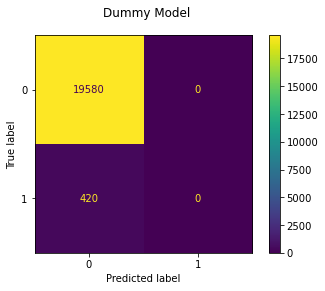

In [33]:
# Define dummy classifier pipeline
dummy_clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", DummyClassifier(strategy='most_frequent'))]
)

dummy_clf.fit(X_train, y_train)

# Print recall score
print("Test Recall Score:", recall_score(y_test, dummy_clf.predict(X_test)))

# Confusion matrix for the dummy model
fig, ax = plt.subplots()
fig.suptitle("Dummy Model")
plot_confusion_matrix(dummy_clf, X_test, y_test, ax=ax, values_format='');

## First Simple Model

For my first simple model, I am using a logistic regression model with default parameters. This will serve as a milestone for future model development.

Test Recall Score: 0.5761904761904761


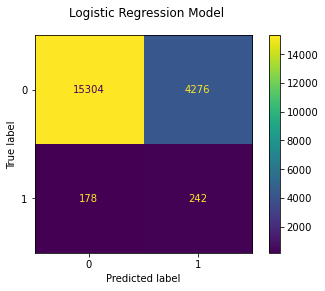

In [34]:
log_clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression(random_state=27))]
)

log_clf.fit(X_train, y_train)

# Print recall score
print("Test Recall Score:", recall_score(y_test, log_clf.predict(X_test)))

# Confusion matrix for the first model
fig, ax = plt.subplots()
fig.suptitle("Logistic Regression Model")
plot_confusion_matrix(log_clf, X_test, y_test, ax=ax, values_format='');

As mentioned previously, an issue for this classification will be overpredicting the minority class ("1", or low APGAR score) on data with the real distribution of the target variable. This simple model performed adequately well, but with such high stakes it may be worth investigating a model that can capture more of the emergencies.

## Final Model

Test Recall Score: 0.65


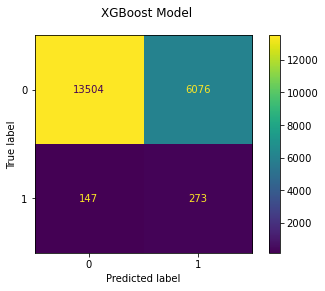

In [35]:
boost = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", xgboost.XGBClassifier(max_depth=19, min_child_weight=27, gamma=1, n_estimators=125, random_state=27))]
)

boost.fit(X_train, y_train)

# Print recall score
print("Test Recall Score:", recall_score(y_test, boost.predict(X_test)))

# Confusion matrix for the final model
fig, ax = plt.subplots()
fig.suptitle("XGBoost Model")
plot_confusion_matrix(boost, X_test, y_test, ax=ax, values_format='');

The finalized XGBoost model had a recall score of around 63% on the test set, predicting 63% of newborn health emergencies before birth takes place. It tended to underpredict non-emergencies, but nonetheless this model represents the highest proportion of emergencies detected out of any of the models analyzed. Additional tuning may be required before deploying the model to scale.

In future study, it may be possible to adjust the model in a more robust manner with the hardware help of cloud computing or by using iterative feature elimination techniques. Another possible avenue to consider would be comparing different resampling methods to see which distribution trains the model in the most effective way. 

## Threshold Manipulation

One possible way to reduce the number of non-emergencies labeled as emergencies would be to adjust the prediction threshold of the model from the default of 0.5. This will naturally lower the recall score and identify fewer real emergencies, but might increase viability of the model by decreasing the potential burden on medical resources.

In [36]:
y_pred_adj = (boost.predict_proba(X_test)[:,1] >= 0.55).astype(bool)

print("0.55 Threshold Recall Score:", recall_score(y_test, y_pred_adj))

confusion_matrix(y_test, y_pred_adj)

0.55 Threshold Recall Score: 0.6095238095238096


array([[14550,  5030],
       [  164,   256]], dtype=int64)

This method could also be used to filter for the most severe cases only, to serve as an additional decision-making tool in a physician's toolkit.

## Addendum: Example Model Prediction

For the presentation, I plan to include the model's prediction of a real-life mother who has given me permission to use their information. Let's see if the model predicts correctly.

In [37]:
# Example information
example = [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 
           0, 1, 0, 26, 37, 0, 0, 0, 5, 5, 10, 10, 0, 0, 72, 25, 190, 30, 0, 1, 32]

# Turn feature list into dataframe
example_df = pd.DataFrame(example).T
example_df.columns = X_train_processed.columns

In [38]:
# Instantiate model and fit to training data
example_boost = xgboost.XGBClassifier(max_depth=19, min_child_weight=27, gamma=1, n_estimators=125, random_state=27)
example_boost.fit(X_train_processed, y_train)

# Predict on example data
example_boost.predict_proba(example_df)

array([[0.22943938, 0.7705606 ]], dtype=float32)

In this case the model predicted that the child would need emergency medical intervention with a 77% likelihood, which lines up with what actually happened!

## Saving Train and Test Data For Gridsearch Notebook

In order to conserve memory, I saved the samples created in this notebook for use in the gridsearch notebook. The code is preserved here.

In [39]:
# filepath1 = Path('data/X_train.csv')  
# filepath1.parent.mkdir(parents=True, exist_ok=True)  
# X_train.to_csv(filepath1)

# filepath2 = Path('data/X_test.csv')  
# filepath2.parent.mkdir(parents=True, exist_ok=True)  
# X_test.to_csv(filepath2)

# filepath3 = Path('data/y_train.csv')  
# filepath3.parent.mkdir(parents=True, exist_ok=True)  
# y_train.to_csv(filepath3)

# filepath4 = Path('data/y_test.csv')  
# filepath4.parent.mkdir(parents=True, exist_ok=True)  
# y_test.to_csv(filepath4)